# 1083 Albumin Initial ML

### By: Ian Weimer

In [121]:
import imblearn
print("Imbalanced-Learn", imblearn.__version__)

Imbalanced-Learn 0.7.0


In [122]:
#print("Imbalanced-Learn", imbalanced-learn.__version__)

## Imports

In [123]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [124]:
df = pd.read_csv('K85_matched_1.csv')

In [125]:
df.CCI.value_counts()

3     984
1     964
0     818
2     781
4     732
5     631
6     431
7     366
8     224
9     164
10     84
11     63
12     27
13     22
14     13
16      7
15      6
17      1
Name: CCI, dtype: int64

In [126]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [127]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  06a78daa-d369-4af6-baa9-bb081f9ae6eb    0          1    1      0     0   
1  af2557de-fa1a-4652-8a59-2fcfad3ce4a1    1          0    1      1     3   
2  611d8627-bdd7-4b7f-a849-9350bf32a088    1          1    4      2     5   
3  058e7714-06bc-4c29-bf02-79e654d0f5c9    1          1    1      1     3   
4  acf2ebaa-eca0-48db-b5a3-19dc2c8f2adc    0          0    0      0     0   

   diuretic  propensity_score  propensity_logit  albumin_24hrs  \
0         0          0.408427         -0.370474              1   
1         1          0.926909          2.540152              1   
2         0          0.989776          4.572719              1   
3         1          0.976474          3.725848              1   
4         0          0.096846         -2.232769              1   

                               personid   LOS_days  90_day_mortality  \
0  35fe0efc-bab7-4f2a-830a-f24f904d1440   6.805556                 0   
1  42f14dab-4f7b-416e-8fe7-5fcc16a139ee   9.620139                 0   
2  51ac0f16-8351-4a56-a08f-9c04af96fd3f   1.940972                 1   
3  574c98e8-d7ae-480d-81d0-41f142064aba  21.387500                 0   
4  5dbb63a3-5fcd-4899-8019-d5eca74d232e   5.479167                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                   7             1.0        1  
1                 1.0                  35             2.0        1  
2                 0.0                   0             1.0        1  
3                 1.0                  38             1.0        1  
4                 0.0                  21             1.0        1

In [128]:
df.shape

(6318, 17)

In [129]:
df.propensity_logit.describe()

count    6318.000000
mean        1.630962
std         1.735371
min        -2.277999
25%         0.397990
50%         1.735108
75%         2.979980
max         5.267174
Name: propensity_logit, dtype: float64

## Add ICU-variable based dataframes

### ICU Cohort

### Non ICU Cohort

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [130]:
m_90d_a24 = df[df['albumin_24hrs'] == 1]['90_day_mortality'].value_counts()
print(m_90d_a24)

0    2421
1     738
Name: 90_day_mortality, dtype: int64


In [131]:
def binary_pct(var):
    pct = (var[1]/(var[1]+var[0])) * 100
    return pct

binary_pct(m_90d_a24)

23.36182336182336

In [132]:
m_90d = df[df['albumin_24hrs'] == 0]['90_day_mortality'].value_counts()
print(m_90d)

0    2822
1     337
Name: 90_day_mortality, dtype: int64


In [133]:
binary_pct(m_90d)

10.667932890155113

In [134]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  06a78daa-d369-4af6-baa9-bb081f9ae6eb    0          1    1      0     0   
1  af2557de-fa1a-4652-8a59-2fcfad3ce4a1    1          0    1      1     3   
2  611d8627-bdd7-4b7f-a849-9350bf32a088    1          1    4      2     5   
3  058e7714-06bc-4c29-bf02-79e654d0f5c9    1          1    1      1     3   
4  acf2ebaa-eca0-48db-b5a3-19dc2c8f2adc    0          0    0      0     0   

   diuretic  propensity_score  propensity_logit  albumin_24hrs  \
0         0          0.408427         -0.370474              1   
1         1          0.926909          2.540152              1   
2         0          0.989776          4.572719              1   
3         1          0.976474          3.725848              1   
4         0          0.096846         -2.232769              1   

                               personid   LOS_days  90_day_mortality  \
0  35fe0efc-bab7-4f2a-830a-f24f904d1440   6.805556                 0   
1  42f14dab-4f7b-416e-8fe7-5fcc16a139ee   9.620139                 0   
2  51ac0f16-8351-4a56-a08f-9c04af96fd3f   1.940972                 1   
3  574c98e8-d7ae-480d-81d0-41f142064aba  21.387500                 0   
4  5dbb63a3-5fcd-4899-8019-d5eca74d232e   5.479167                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                   7             1.0        1  
1                 1.0                  35             2.0        1  
2                 0.0                   0             1.0        1  
3                 1.0                  38             1.0        1  
4                 0.0                  21             1.0        1

In [135]:
df.drop(columns=['encounterid', 'personid', 'propensity_score', 'propensity_logit', 'albumin', 'albumin_timing', 'diuretic'], inplace=True)

In [136]:
df.drop(columns=['90_day_readmission', 'LOS_days', 'hospital_free_days'], inplace=True)

In [137]:
# df.drop(columns=['MELD'], inplace=True)

In [138]:
df.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  albumin_24hrs  90_day_mortality
0    0          1    1      0     0              1                 0
1    1          0    1      1     3              1                 0
2    1          1    4      2     5              1                 1
3    1          1    1      1     3              1                 0
4    0          0    0      0     0              1                 0

In [139]:
# remove non-baseline variables

# df.drop(columns=['beta_blocker', 'bl_albumin_value', 'SAPS', 'qSOFA'], inplace=True)

In [140]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA         SEWS  \
count  6318.000000  6318.000000  6318.000000  6318.000000  6318.000000   
mean      0.311808     0.404717     3.564577     0.782210     1.736942   
std       0.463268     0.490876     2.836675     0.813679     1.924357   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     1.000000     0.000000     0.000000   
50%       0.000000     0.000000     3.000000     1.000000     1.000000   
75%       1.000000     1.000000     5.000000     1.000000     3.000000   
max       1.000000     1.000000    17.000000     3.000000    14.000000   

       albumin_24hrs  90_day_mortality  
count     6318.00000       6318.000000  
mean         0.50000          0.170149  
std          0.50004          0.375793  
min          0.00000          0.000000  
25%          0.00000          0.000000  
50%          0.50000          0.000000  
75%          1.00000          0.000000  
max          1.00000          1.000000

In [141]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

In [142]:
df['90_day_mortality'].value_counts()

0    5243
1    1075
Name: 90_day_mortality, dtype: int64

In [143]:
df[df['albumin_24hrs'] == 1]['CCI'].describe()

count    3159.000000
mean        3.478632
std         2.599405
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        15.000000
Name: CCI, dtype: float64

In [144]:
df[df['albumin_24hrs'] == 0]['CCI'].describe()

count    3159.000000
mean        3.650522
std         3.053574
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        17.000000
Name: CCI, dtype: float64

## Modeling

In [145]:
# establish target feature, LOS_days, as y feature
y = df['90_day_mortality']
# drop target feature from features dataframe
X = df.drop(columns = ['90_day_mortality'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [146]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'SEWS', 'albumin_24hrs'], dtype='object')

## Standardize Data

In [147]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [148]:
X.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  albumin_24hrs
0    0          1    1      0     0              1
1    1          0    1      1     3              1
2    1          1    4      2     5              1
3    1          1    1      1     3              1
4    0          0    0      0     0              1

In [149]:
X.shape

(6318, 6)

## Train Test Split

In [150]:
#sm = SMOTENC(random_state=42, categorical_features = [0, 1, 3, \
#                                                     5])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [151]:
sm = SMOTENC(random_state=42, categorical_features = [0, 1, 3, \
                                                     5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [152]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [153]:
# what tree uses in flowchart

y_train.value_counts()

0    4191
1    4191
Name: 90_day_mortality, dtype: int64

In [154]:
X_train.albumin_24hrs.value_counts()

1    4910
0    3472
Name: albumin_24hrs, dtype: int64

In [155]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [156]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

In [157]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

Feature: ICU Score: 0.25693
Feature: Cirrhosis Score: 0.16093
Feature: CCI Score: 0.08311
Feature: qSOFA Score: 0.22726
Feature: SEWS Score: 0.04331
Feature: albumin_24hrs Score: 0.53603


In [158]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

               Importance
albumin_24hrs    1.709207
ICU              1.292951
qSOFA            1.255153
Cirrhosis        1.174606
CCI              1.086656
SEWS             1.044262


In [159]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [160]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2808 1383]
 [1425 2766]]


In [161]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67      4191
           1       0.67      0.66      0.66      4191

    accuracy                           0.66      8382
   macro avg       0.67      0.66      0.66      8382
weighted avg       0.67      0.66      0.66      8382



In [162]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[718 334]
 [ 63 149]]


In [163]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1052
           1       0.31      0.70      0.43       212

    accuracy                           0.69      1264
   macro avg       0.61      0.69      0.61      1264
weighted avg       0.82      0.69      0.72      1264



## 1: Decision Tree 

In [164]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.06554
Feature: Cirrhosis Score: 0.04832
Feature: CCI Score: 0.28918
Feature: qSOFA Score: 0.24719
Feature: SEWS Score: 0.05741
Feature: albumin_24hrs Score: 0.29236


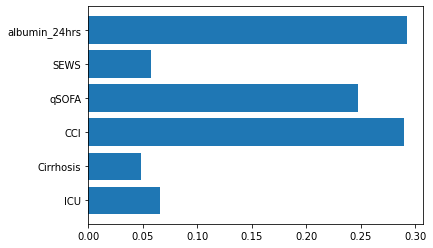

In [165]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [166]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [167]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2727 1464]
 [1130 3061]]


In [168]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68      4191
           1       0.68      0.73      0.70      4191

    accuracy                           0.69      8382
   macro avg       0.69      0.69      0.69      8382
weighted avg       0.69      0.69      0.69      8382



In [169]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[679 373]
 [ 55 157]]


In [170]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.93      0.65      0.76      1052
           1       0.30      0.74      0.42       212

    accuracy                           0.66      1264
   macro avg       0.61      0.69      0.59      1264
weighted avg       0.82      0.66      0.70      1264



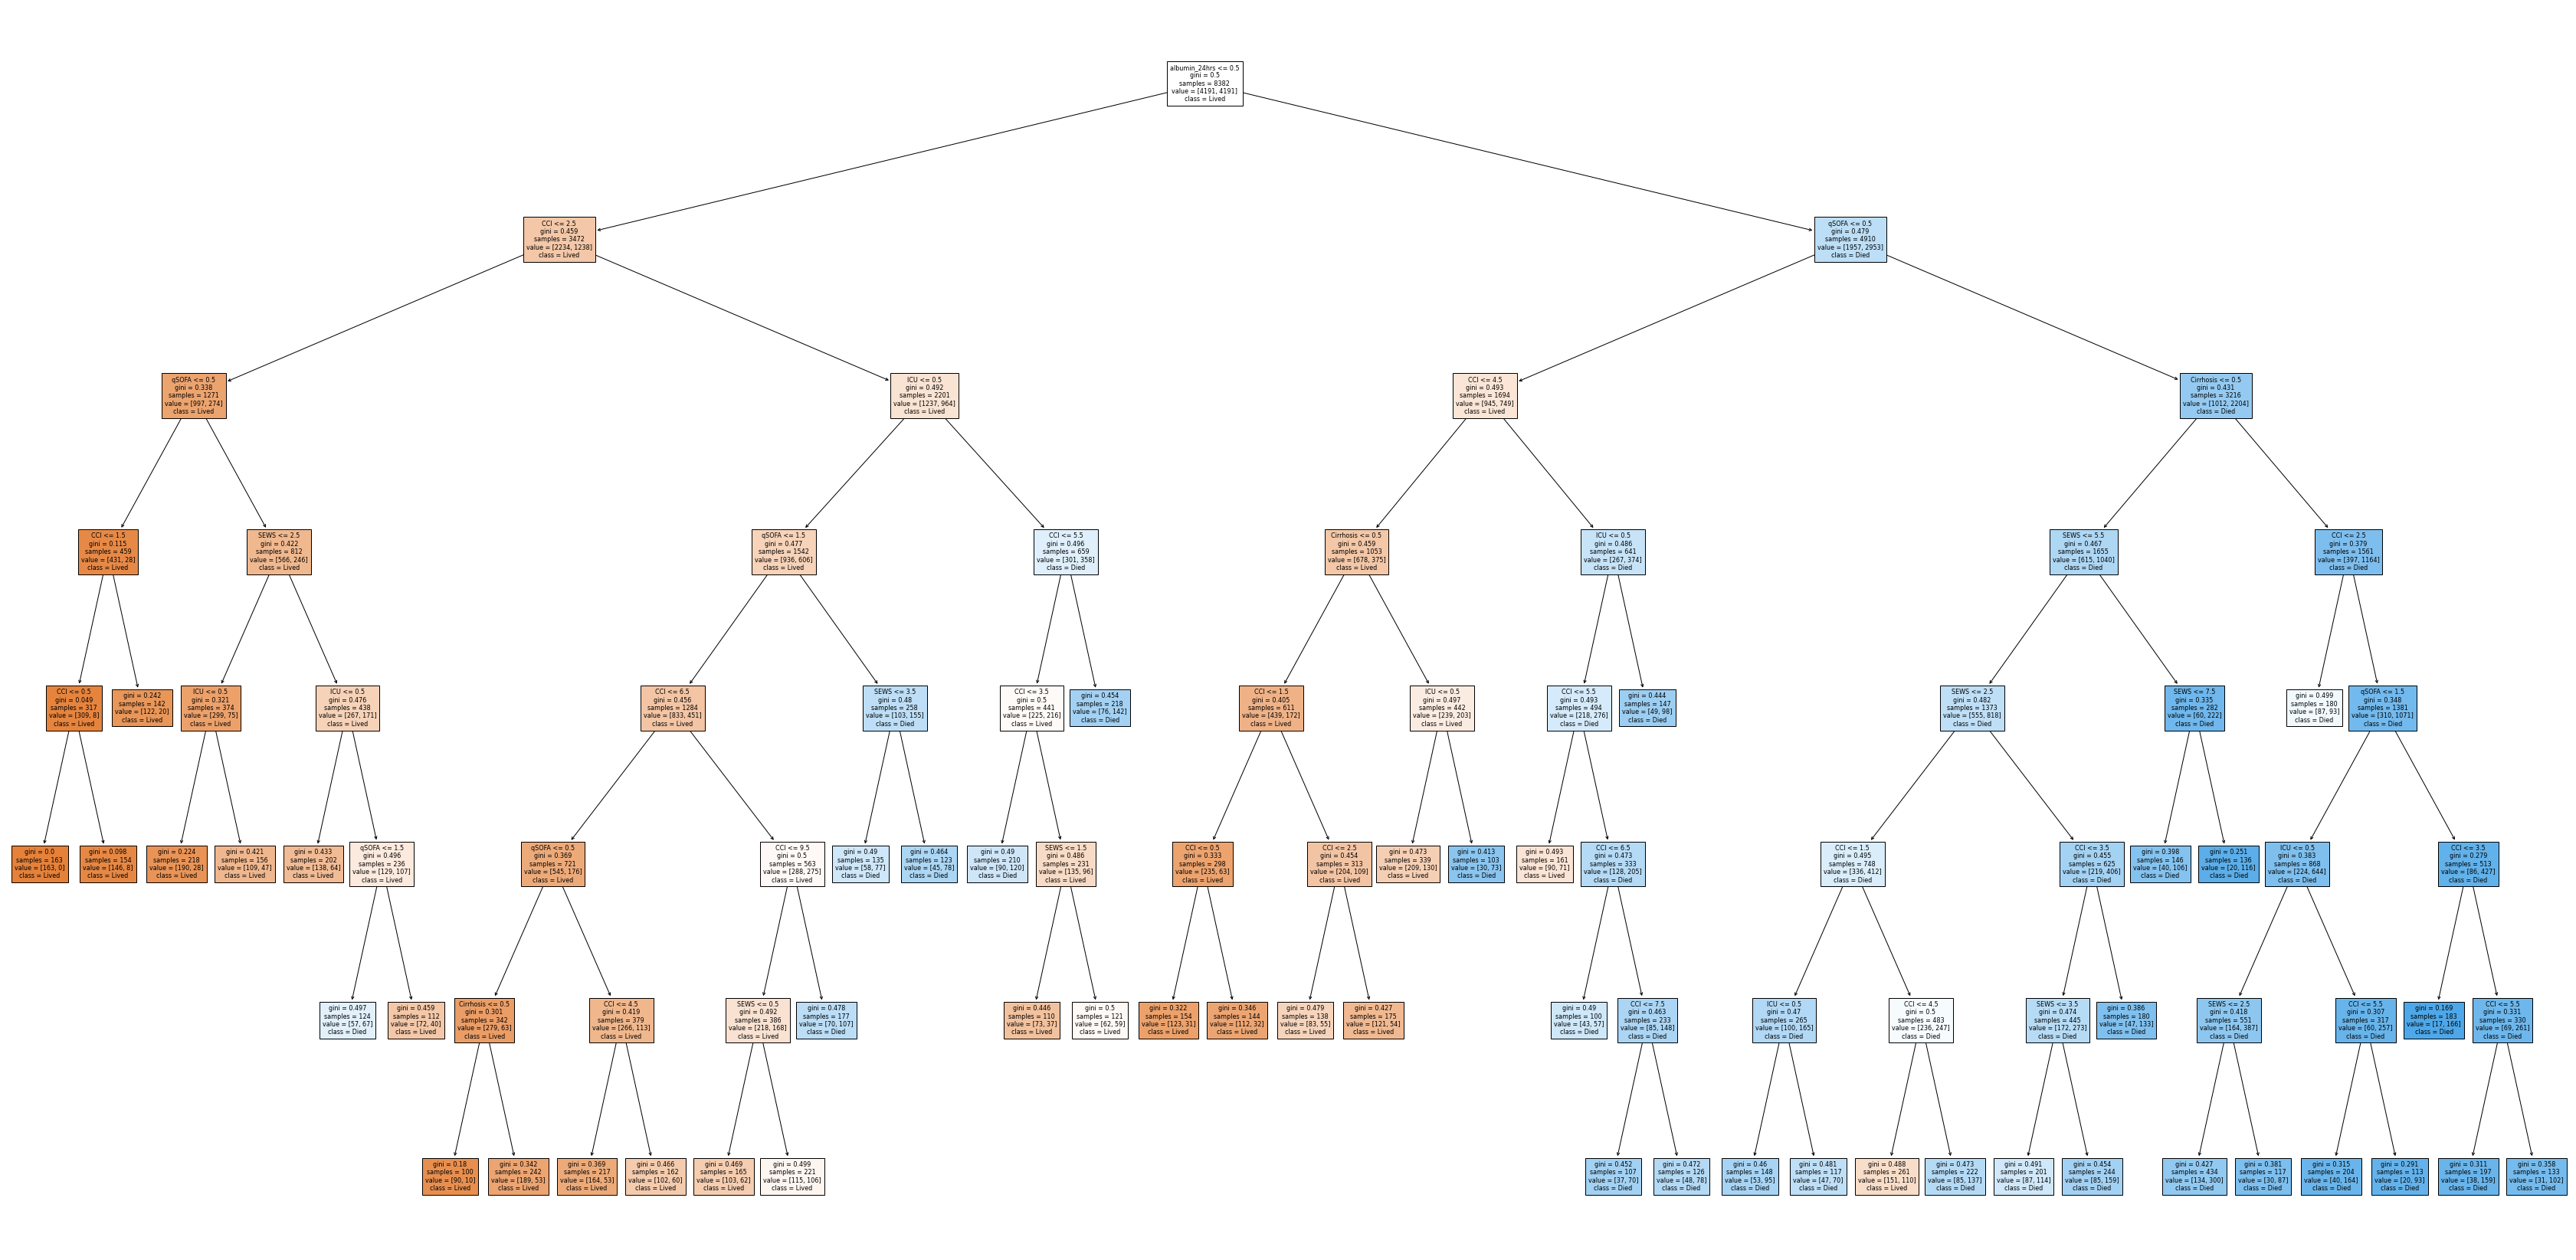

In [171]:
feature_names = X_train.columns.tolist()
class_names = ['Lived', 'Died']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [172]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DM_DT_D7_PSM_MATCHED_2.png')

True

## Random Forest

In [173]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [174]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [175]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2783 1408]
 [1241 2950]]


In [176]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.69      0.66      0.68      4191
           1       0.68      0.70      0.69      4191

    accuracy                           0.68      8382
   macro avg       0.68      0.68      0.68      8382
weighted avg       0.68      0.68      0.68      8382



In [177]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[719 333]
 [ 69 143]]


In [178]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1052
           1       0.30      0.67      0.42       212

    accuracy                           0.68      1264
   macro avg       0.61      0.68      0.60      1264
weighted avg       0.81      0.68      0.72      1264



Feature: ICU Score: 0.05416
Feature: Cirrhosis Score: 0.05572
Feature: CCI Score: 0.24306
Feature: qSOFA Score: 0.22584
Feature: SEWS Score: 0.09719
Feature: albumin_24hrs Score: 0.32403


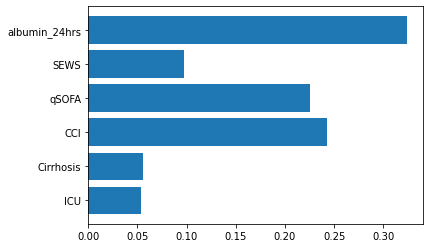

In [179]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()